# Lab 2: Teil earthquake epicenter localisation from Monte Carlo


## Estimation of an epicenter: direct plot of the volumetric probability
---

**Authors**: Antoine Lucas (lucas@ipgp.fr) / Grégory Sainton (sainton@ipgp.fr)

**Date**: January. 2021 (init. version from Dec. 2019). Note that the notebook was created before any publication and references. We Updated the notebook with the comparision between the published values and ours for the final step of the lab. The InSAR was also done before any published material. 

----

**Purpose**: On Nov 11 2019, an EQ occured nearby Teil, (France). In this lab, we propose to estimate the location of the epicenter by a simple Monte Carlo method. 


**Data** 
- We will use 7 stations from the RESIF network (https://www.resif.fr/) and explore some parameters of the problem. 
- The conversion from miniseed to flat csv has been done by G. Sainton using the ConvertmseedToflat.py script (available on the repository). 
- The InSAR displacement map has been computed by A. Lucas using SNAP. 

**You will learn**: 
- How to prepare and clean the seismic data from different sources then you will implement Monte Carlo simulations to invert the data and find the epicenter of the earthquake.
- This excercice is based on the famous Albert Tarantola's example that can be found on http://www.ipgp.fr/~tarantola/. 


### Organization of the notebook

1. Quick introduction to the method

2. Data reading and preprocessing.

3. Inverse problem
    - 3.1. Theoritical reminds
    
    - 3.2. Working with 3 stations
    
    - 3.3. Working with all the stations
    
    - 3.4. Deal with biases in the dataset
    
    - 3.5. Introducing a priori information from InSAR

____________________________________________________________________

## 1. Quick introduction to the method

>Experiments suggest physical theory, and physical theory predict the outcome of experiments. The comparision of the predicted outcome and the observed outcome allows us to ameliorate the theory. It in the "physical theory" we include the physical parameters describing the system under study, then inverse problem theory is about the quantitative rules to be used for this comparison between predictions and observations. (**Inverse Problem Theory**, A. Tarantola, Siam Ed., 2005, p.20). Note that the `Bib` directory on the GitLab contains a paper that describes the method.

Solving a "forward problem" means to predict the error-free values of the observable parameters **d** that would correspond to a given model **m**. It can be formally written as

$\begin{equation}
m \longmapsto d=g(m) \tag{1}
\end{equation}$


Where **g(.)** is the forward operator, which means the mathematical model of the physical system under study.

In our problem, 
- the model parameters **m** are the coordinates of the epicenter of the earthquake, i.e. a 2 terms vector.

$\begin{equation}
m=(X,Y)  \tag{2}
\end{equation} $


- the data parameters **d** are the arrival times at some seismic stations, i.e. 7 in our case.

$\begin{equation}
d=(t^1, t^2, t^3, t^4, t^5, t^6, t^7) \tag{3}
\end{equation} $


## 2. Data reading and preprocessing.

#### Useful informations to solve the problem

- The event occured at 2019-11-11 @ 10:52:45.5
- The coordinates of the 7 stations are stored in the file `./data/station_coord_Lambert93.csv`.

- We will use the 100Hz sismograms of these stations for the P waves arrival time. They are saved as csv files in the directory `./data/csv/`


#### Before going further, execute the following cell to import all the necessary libraries for the lab.

In [1]:
import glob
from datetime import datetime
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

### 2.1. RESIF Stations

The coordinates in Lambert 93 of the RESIF stations are saved in the file `data/station_coord_Lambert93.csv`

1. Using `Pandas` read the file and inspect the data
2. Plot the stations locations using your favorite graphic lib.


#### Solution Pandas

In [2]:
# 1. Open the file and inspect the data
station_coord_file = "./data/station_coord_Lambert93.csv"

data_coord = pd.read_csv(station_coord_file)
data_coord.head(10)

station   latitude  longitude  elevation
0    BANN  6363993.0     792139      447.0
1    OGCB  6418973.0     865628      738.0
2    OGCC  6373282.0     902942     1250.0
3    OGCN  6452684.7     864138      300.0
4    OGDF  6386363.0     864306      709.0
5    RUSF  6318935.0     899380      499.2
6    SAUF  6317666.0     869110      230.0

#### Solution Pandas

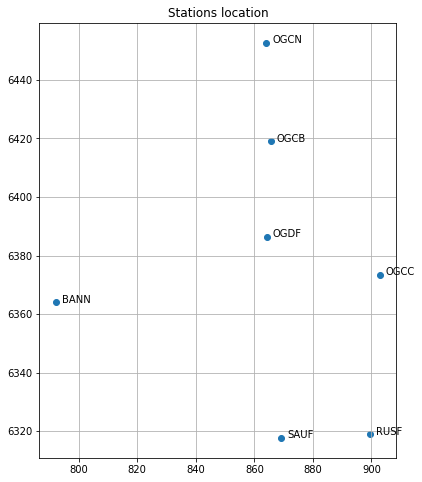

In [3]:
# 2. Plot the stations location  
# Here, example with SEABORN
fig, ax = plt.subplots(figsize=(12,8))
#sns.scatterplot(data = data_coord, x="longitude", y= "latitude")
ax.scatter(data_coord["longitude"]/1000., data_coord["latitude"]/1000.)
ax.set_xlabel = "Longitude (km)"
ax.set_ylabel = "Latitude (km)"
ax.grid(True)
plt.title('Stations location')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']/1000.+2, point['y']/1000., str(point['val']))

label_point(data_coord.longitude, data_coord.latitude, data_coord.station, plt.gca()) 
ax.set_aspect('equal', 'box')
plt.show()

##### Another solution to read the files : 

One can also your a more classical way to open CSV files using the ```csv``` library
Here is an example:

```python
workingdir = "./dataTeil/"

with open(workingdir+'station_coord_Lambert93.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ')
    for row in spamreader:
         print(', '.join(row))
            
types = ['S4', 'f8', 'f8', 'f8']
data = np.genfromtxt(workingdir+'station_coord_Lambert93.csv', 
                     dtype=types, delimiter=',', names=True)```

### 2.2. Read the sismograms


Now, we collect the waveforms (seismic records) from flat csv and select the correct files according to the small list of station. Note that the following data are raw data in Digital Units (DU) and do not reflect the actual velocity. 

#### Questions 
1. Create a sublist of files with the sismograms of the 7 stations with 100Hz sampling with the location code `00` (note that for RUSF station, you must select the location `07`)

2. Seismograms will be plotted later during the Monte Carlo parts


**hints**

- File are named as follow : ```Country_Station_Location_Sampling_UTC-Date_test.csv```
- Beware to get 7 files at the end.
- ```glob``` command from ```glob``` library is not useless to list files in a directory...
- The event time (given in the introduction must be converted in `timestamp`)
- Each file is made with the same structure: 

| timestamp | UTC Time | HHE | HHN | HHZ |
| --------- | -------- | ----| --- | --- |

where
- timestamp is the absolute time in second since 1970, january, 1$^{st}$;
- UTC Time is the universal time;
- HHE is the amplitude in DU of the east channel;
- HHN is the amplitude in DU of the north channel;
- HHZ is the amplitude in DU of the vertical channel;
  

#### 1. Solution

In [4]:
listcsv00      = glob.glob("./data/csv/"+"*00_100*_test.csv")
listcsv07      = glob.glob("./data/csv/"+"*07_100*_test.csv")
station_list = data_coord["station"].to_list()
file_list = listcsv00 + listcsv07

data_coord["filename"] = "Unknown"

# The previous list contains already 7 files but i prefer check to avoid multiplets

for index in data_coord.index:
    for f in file_list:
        if f.find(data_coord["station"][index]) !=-1:
            data_coord["filename"][index] = f


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### 2.3. P wave arrival time

Normally, if your are a seismologist, you know how to pick arrival times in the seismograms. 
If you are ready to spend time to pick the P wave arrival times then plot all the seismograms and pick the times.


Otherwise, all these arrival times are already saved for you in a JSON file `time_picking.json` in the directory `data/picking`. It contains the arrival times and their uncertainties

#### Questions : 

- Load the file in a Pandas DataFrame ```data_picking```
- Inspect the result

**hints:**
- In pandas, reading a JSON format file can be done with `pd.read_json()`

#### Solutions

In [5]:
data_picking = pd.read_json("./data/picking/time_picking.json")
data_picking.head()

station  Tobs  sigma
0    BANN   7.0    2.0
1    OGCB   8.7    4.0
2    OGCC  53.4    1.2
3    OGCN  14.2    3.0
4    OGDF   6.6    1.0

## 3. Inverse problem
### 3.1. Theoritical reminds

(This few ideas come from the lectures or from A.Tarantola's book (reference given above)).

The coordinates of the seismic stations and the velocity of the P wave are assumed which means that the uncertainties are supposed to be negligible in comparison with the uncertainties of the observed arrival times. 

For a given (X, Y), the arrival times $t^i$ (for $i=1..7$) of the seismic wave at the seismic stations can be computed as

$\begin{equation}
t^i = g^i(X,Y) = \frac{1}{v}\sqrt{(x^i-X)^2+(y^i-Y)^2} \tag{3}
\end{equation}$

For sake of simplicity, we will consider only one velocity $v$, but in reality, each station corresponds to a specific $v^i$ due to heterogeneities of the geological context.

From the lecture, we know that the *a  priori* information $\sigma(m)$ is a combination of all informations we have which can be expressed as 

$\begin{equation}
\sigma(m) = k.\rho(m).L(m) \tag{4}
\end{equation}$

where $k$ is a normalization constant, $\rho(m)$, the *a priori* and $L(m)$ the likelihood function.

- If we consider that the uncertainties are Gaussian then the likelihood function is expressed as:

$\begin{equation}
L_G(m) = k'.e^{-\frac{1}{2} \sum\limits_{i=1}^{n} \left(\frac{t_{i}-t_{obs}}{\sigma_i} \right)^2} \tag{5}
\end{equation}$

where $k'$ is a normalization constant. 


### 3.2. Working with 3 stations

Let's start with a limited number of observation (that comes with a biais, stations are aligned). 
Using the three stations (OGCN, OGCB, OGDF) along the Rhône valley built inverse problem. 

1. Define your parameters space:
    - Horizontal coordinates range: 
    ```python 
    Xmin=7.8e5; Xmax=9.5e5;
    ``` 
     
    - Vertical coordidates range:
    ```python 
    Ymin=6.3e6; Ymax=6.46e6;
    ```
    
    - Concerning the wave velocity $v$, we can take a crude estimation and based on the direct model from the rough time picking and the EQ time estimates, we take into consideration the geological sedimentary context (see https://en.wikipedia.org/wiki/P_wave) :  
    ```python 
    v=5341
    ```
 
    - Finally, we define a number of runs for your Monte Carlo
    ```python 
    n_run=50000
    ```
    
    - Put all these parameters in a dictionnary ```param_space```
        
2. Select the dataset 
    - 2.1. Select your 3 stations (listed above)
    
    - 2.2. Then concatenate the informations $T^{obs}_i$ and $\sigma_i$ for each station. 
    
3. Plot the time series of these three stations 
 
4. Implement the function ```MC_gauss(problem, param_space)```


5. Implement the function ```plot_dist_obs(gobs, problem, title)``` to plot the distributions of probability and the station locations.

  




####  1. Define your parameters space

##### Solutions

In [6]:
# 1.Define your parameters space
param_space = {}

param_space["Xmin"] = 7.8e5 
param_space["Xmax"] = 9.5e5;
param_space["Ymin"] = 6.3e6; 
param_space["Ymax"] = 6.46e6;
param_space["n_run"]= 5e4;  
param_space["v"]    = 5341; 

#### 2. Select the stations 

**hints**
Have a look on ```.isin()``` function in Pandas 

Example of output of the DataFrame: 
<img src = "./Figures/OutputProblem1.png" width="300">

##### Solution

In [7]:
# 2. Select the data of the three stations
problem1 = data_coord[data_coord["station"].isin(["OGCN", "OGCB", "OGDF"])]



# 3. Add Tobs and sigma for these stations
problem1 = problem1.merge(data_picking,on='station', how='inner')
problem1.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


station   latitude  longitude  elevation  \
1    OGCB  6418973.0     865628      738.0   
3    OGCN  6452684.7     864138      300.0   
4    OGDF  6386363.0     864306      709.0   

                                            filename  Tobs  sigma  
1  ./data/csv/FR_OGCB_00_100.0_2019-11-11T10_50_1...   8.7    4.0  
3  ./data/csv/FR_OGCN_00_100.0_2019-11-11T10_50_1...  14.2    3.0  
4  ./data/csv/FR_OGDF_00_100.0_2019-11-11T10_50_1...   6.6    1.0

#### 3. Plot the time series of these three stations 

1. Plot the time series of each stations. The origin time is the Event time of the earthquake. 
2. Overplot the arrival time ```Tobs``` for each stations.
3. A windows of $200$ seconds is good enough for the each series.

##### Solution

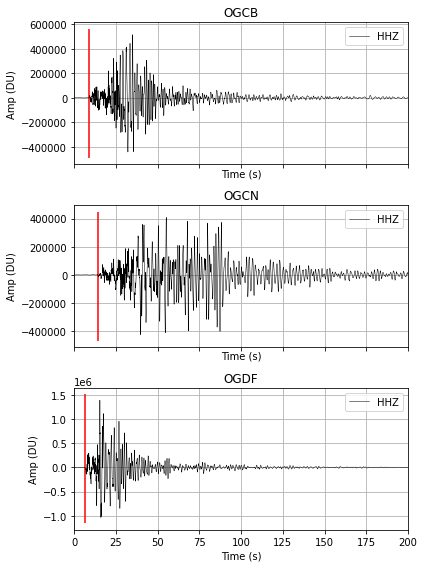

In [8]:
# define the event time in datatime format then in timestamp
dd=datetime(2019,11,11,10,52,45,5)
timestamp = (dd - datetime(1970, 1, 1)).total_seconds()

# put the dataframe to plot

def plot_trace(df2plot):
    fig,axs = plt.subplots(nrows=len(df2plot), ncols=1, figsize=(6,8), sharex= True)

    # loop over the pandas structures to open the files
    plt_idx = 0
    for index, row in df2plot.iterrows():
        sismo = pd.read_csv(row["filename"], delimiter=',')
        sismo["relative_time"] = sismo["time"] - timestamp
        axs[plt_idx].plot(sismo["relative_time"], sismo["HHZ"], 
                    color= "black", lw=0.5, label = "HHZ")
        axs[plt_idx].set_xlabel("Time (s)")
        axs[plt_idx].set_ylabel("Amp (DU)")
    
        # plot the arrival time
        lower, upper = axs[plt_idx].get_ybound() 
        axs[plt_idx].vlines(data_picking.iloc[index]["Tobs"], 
                      ymin=lower, ymax = upper, color = "red")
    
        axs[plt_idx].grid(True)
        axs[plt_idx].set_title(row["station"])
        axs[plt_idx].legend()
        axs[plt_idx].axes.set_xlim(0, 200)
        plt_idx+=1
    fig.tight_layout()
    plt.show()
    
plot_trace(problem1)

#### 4. Implement the function ```MC_gauss(problem, param_space)```

The idea is to estimate n_run times the probability density $L$ for each random $(X, Y)$ and save all the $(X, Y, L)$ into a single array ```gobs``` which is returned.

**hints**
- Using ```random.uniform``` pick a uniform random value in the $X_{eq}$ range of the parameters space. Pick another for $Y_{eq}$
- Output array has the dimension (n_run, 3)

##### Solution

In [9]:
def MC_Gauss(problem1, param_space):
    
    Tstep = problem1["Tobs"].to_numpy()
    Sstep = problem1["sigma"].to_numpy()
    Xstep = problem1["longitude"].to_numpy()
    Ystep = problem1["latitude"].to_numpy()

    gobs=[]

    for idx in range(0, int(param_space["n_run"])):

        Xeq = random.uniform(param_space["Xmin"], param_space["Xmax"])
        Yeq = random.uniform(param_space["Ymin"], param_space["Ymax"])
        
        Tcal = np.sqrt((Xeq - Xstep)**2 + (Yeq - Ystep)**2)/param_space["v"]

        LFG = ((Tcal - Tstep)**2/Sstep**2)
        LFG = np.exp(-1/2.*np.sum(LFG))

        gobs.append([Xeq, Yeq, LFG]);

    gobs  = np.array(gobs)

    return gobs

# RUN THE CODE
gobs = MC_Gauss(problem1, param_space)

#### 5. Implement the function ```plot_dist_obs(gobs, problem, title)``` to plot the distributions of probability and the station locations. 

**hints**
- ```gobs``` is the (n_run, 3) array output from the function ```MC_gauss(problem, param_space)```
- You could use ```ax.scatter``` plot the array ```gobs``` and change the color in function of the density $L$


##### Solutions

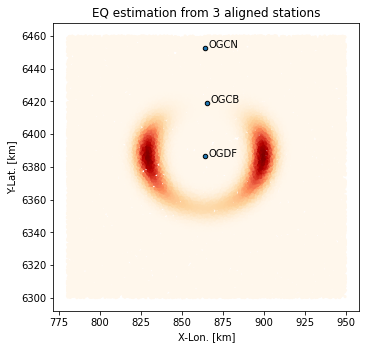

In [10]:
def plot_dist_obs(gobs, problem, title):

    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(gobs[:,0]/1000., gobs[:,1]/1000., edgecolors='none', 
               s=10, c=gobs[:,2], cmap=plt.cm.OrRd)          
    ax.scatter(problem["longitude"]/1000., problem["latitude"]/1000.,
               edgecolors='k',s=20)
    ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
    ax.set_aspect('equal', 'box')
    for i, point in problem.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
        
    
    plt.show()

# RUN THE CODE
plot_dist_obs(gobs, problem1, 'EQ estimation from 3 aligned stations')
 

#### Conclusion 


Since the three stations are aligned, the solution found is ambiguous. So, we need to better define our problem. Let's add all the stations then.



### 3.3. Working with all the stations

This time, restart the simulation taking into account **all the stations**


#### Solutions

station   latitude  longitude  elevation  \
0    BANN  6363993.0     792139      447.0   
1    OGCB  6418973.0     865628      738.0   
2    OGCC  6373282.0     902942     1250.0   
3    OGCN  6452684.7     864138      300.0   
4    OGDF  6386363.0     864306      709.0   

                                            filename  Tobs  sigma  
0  ./data/csv/FR_BANN_00_100.0_2019-11-11T10_50_1...   7.0    2.0  
1  ./data/csv/FR_OGCB_00_100.0_2019-11-11T10_50_1...   8.7    4.0  
2  ./data/csv/FR_OGCC_00_100.0_2019-11-11T10_50_1...  53.4    1.2  
3  ./data/csv/FR_OGCN_00_100.0_2019-11-11T10_50_1...  14.2    3.0  
4  ./data/csv/FR_OGDF_00_100.0_2019-11-11T10_50_1...   6.6    1.0

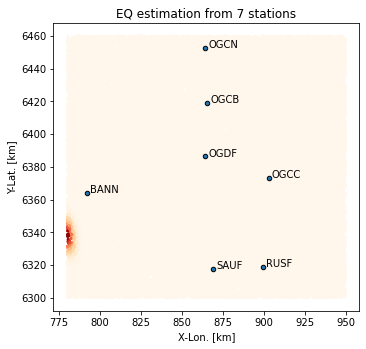

In [11]:
# 2. Select the data of the three stations
problem2 = data_coord.copy()

# 3. Add Tobs and sigma for these stations
problem2["Tobs"] = data_picking["Tobs"]
problem2["sigma"] = data_picking["sigma"]

display(problem2.head())

# RUN THE CODE
gobs2 = MC_Gauss(problem2, param_space)

plot_dist_obs(gobs2, problem2, 'EQ estimation from 7 stations')

#### Conclusions
Compared to previous problem, we found only one area but the location seems odd. As stated, the epicenter is supposed to be inside the domain, here we hit the edge. 
Let's have a look at the data of the problem.

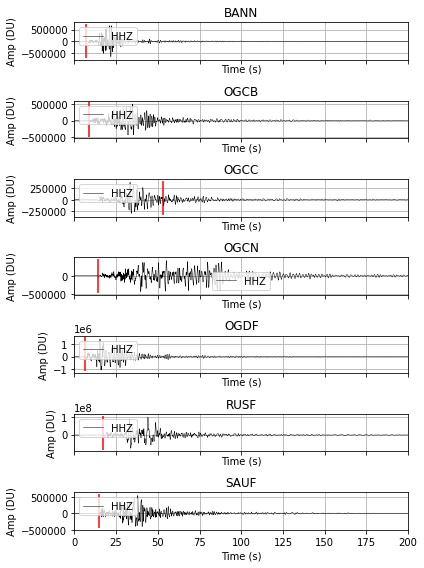

In [12]:
plot_trace(problem2)

As we can see on these plots, the time picking for OGCC is erroneous. Actually, this means that the problem is statistically biaised. In fact, we introduced an aberrant arriving time ```Tobs```  at  one station.  Because the Gaussian assumption is used, the result is very sensitive to big errors (even if there is a small number of them).

### 3.4. Deal with biases in dataset

 Your are invited to consider changing the Gaussian model by the more robust Laplacian model,
and/or introducing a priori information.  

First, here is the Laplace distribution:

$\begin{equation}
L_L(m) = k.exp{\left[-\sum\limits_{i=1}^{n} \frac{\lvert t_{i}-t_{obs}\lvert}{\sigma_i}\right]} \tag{6}
\end{equation}$

where $k$ is a normalization constant. For sake of simplicity of this lab, we can ignore it. 

#### Questions

1. Modify the function ```MC_Gauss(...)``` to ```MC_Laplace(...)``` to use the Laplacian distribution.
2. Make your function run over the parameters space and plot the results
3. Which station is concerned by the biais?



##### Solutions

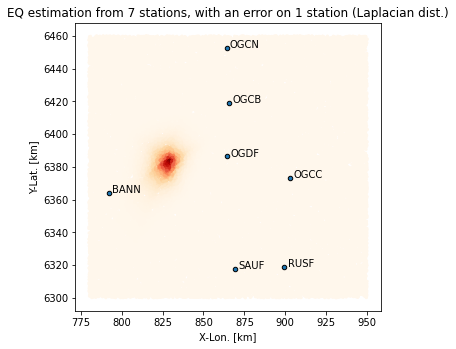

In [13]:
def MC_Laplace(problem1, param_space):
    
    Tstep = problem1["Tobs"].to_numpy()
    Sstep = problem1["sigma"].to_numpy()
    Xstep = problem1["longitude"].to_numpy()
    Ystep = problem1["latitude"].to_numpy()

    gobs=[]

    for idx in range(0, int(param_space["n_run"])):

        Xeq = random.uniform(param_space["Xmin"], param_space["Xmax"])
        Yeq = random.uniform(param_space["Ymin"], param_space["Ymax"])
        
        Tcal = np.sqrt((Xeq - Xstep)**2 + (Yeq - Ystep)**2)/param_space["v"]

        LFG = np.divide(np.abs(Tcal - Tstep), Sstep)
        LFG = np.exp(-1/2.*np.sum(LFG))

        gobs.append([Xeq, Yeq, LFG]);

    gobs  = np.array(gobs)
    

    return gobs


# RUN THE CODE
gobs_laplace = MC_Laplace(problem2, param_space)

title='EQ estimation from 7 stations, with an error on 1 station (Laplacian dist.)'
plot_dist_obs(gobs_laplace, problem2, title)

#### Comments
Accounting for a more robust model, the inversion is somewhat less biaised and the result is better. 

### 3.5. Introducing a priori information from InSAR

Now, we will add a priori information from surface displacement obtained from Sentinel-S1 InSAR between the Nov. 6 and Nov. 12. First, we need to read the displacement map. The results are contained in a GeoTiff file ``InSAR_S1/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.tif``. This file comes with Geo Tags in Exifs. For reading these metadata various libs exist, such as ``rasterio``, ``georaster``, ``osgeo``. ``PIL`` and ``OpenCV`` are other image processing libraries that could be also considered. Because you may not have these libs installed, we made a copy into a PNG flat file that can be directly read with ``matplotlib`` or ``scipy`` that should be present in your system. Unfortunately, the Geo tags are no more present into the file and the image footprint in Lamber 93 system needs to be manually provided as:

```python
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]
```

Note that we do a simplistic remapping of the geographic coordinates which is sufficient for the purpose of the lab but a proper warping should be done for accurate results. For those interested in exploring the geospatial approach   the mandatory libs need to be installed. You would need the ``Scripts/ConvertProj.ipynb`` for converting the geographic coordinates into Lambert-93.

In [14]:
ul=[825930.7,6376723.7]
lr=[840754.7,6387758.4]

**Hint**

The ``.imread`` function of ``matplotlib`` returns a ``numpy.array``

In [15]:
im = plt.imread('InSAR_S1/Drome_EQTeil_displacement_VV_06Nov2019_12Nov2019.png')

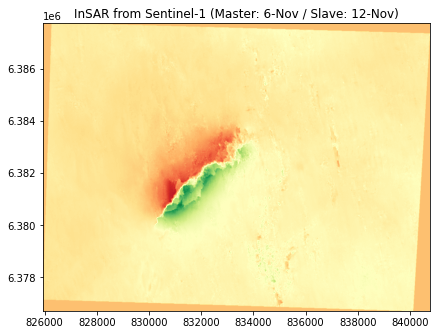

In [16]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.imshow(im,interpolation='bilinear', cmap=cm.RdYlGn,
               extent=[ul[0], lr[0],ul[1], lr[1]])
plt.title('InSAR from Sentinel-1 (Master: 6-Nov / Slave: 12-Nov)')
ax.set_aspect('equal', 'box')

Let's use this location as a prior on the inversion. We take the center of the displaced area in X coordinate (named ``xx``) and we take an uncertainties sigma of  the lateral extend (i.e., ``sigma2``). Then we compute a prior with a Gaussian distribution, centered in ``xx`` with a standard deviation ``sigma2``. We test with ```MC_Gauss(...)``` function and the ``problem2`` defined above : 
```python
xx=832000;
sigma2=2000;
```

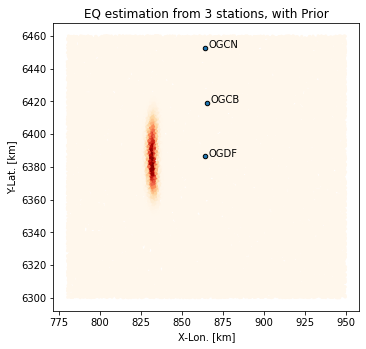

In [17]:
xx=832000; 
sigma2=2000;
#yy=6382000

gobs_InSar = MC_Gauss(problem1, param_space)


fprior =    np.exp( -0.5* (gobs_InSar[:,0] - xx)**2/sigma2**2)

gobs_InSar[:,2] = fprior*gobs_InSar[:,2];
title = 'EQ estimation from 3 stations, with Prior'
plot_dist_obs(gobs_InSar, problem1, title)

#### Comments

Providing an a priori when the observable are biased (i.e., problem1) is strongly helpfull.

Now, let's play with problem2:

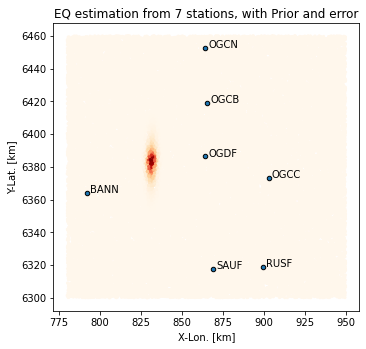

In [18]:
gobs_InSar2 = MC_Laplace(problem2, param_space)
fprior =    np.exp( -0.5* (gobs_InSar2[:,0] - xx)**2/sigma2**2)
gobs_InSar2[:,2] = fprior*gobs_InSar2[:,2];
title = 'EQ estimation from 7 stations, with Prior and error'
plot_dist_obs(gobs_InSar2, problem2, title)

The solution is helped by the a priori knowledge of the problem. 

### 3.6 Further investigations 
First, let evaluate our solution with the actual one.

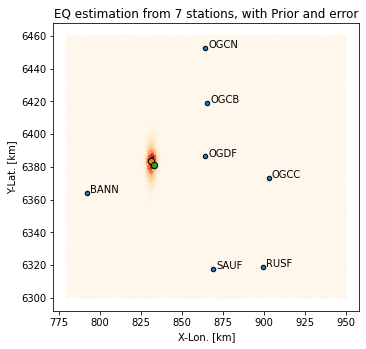

In [19]:
# Here we search for the maximum probability, but keep in mind that the less probable solution are still valid.

ind = np.where(gobs_InSar2[:,2]==np.max(gobs_InSar2[:,2]))
Xprob = gobs_InSar2[ind,0] ; Yprob = gobs_InSar2[ind,1]

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(gobs_InSar2[:,0]/1000., gobs_InSar2[:,1]/1000., edgecolors='none', 
               s=10, c=gobs_InSar2[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem2["longitude"]/1000., problem2["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem2.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

We see that our most probable solution is closed to the actual's. In any case, the actual solution is inside our most probable area. So even with our simplifications and biais for one station, our solution is acceptable.

Now, let's retrieve the correct time arrival at ``OGCC`` from our most probable location.

In [20]:
Xstep=problem2[problem2["station"].isin(["OGCC"])]["longitude"].to_numpy()
Ystep=problem2[problem2["station"].isin(["OGCC"])]["latitude"].to_numpy()
Tcal = np.sqrt((Xprob - Xstep)**2 + (Yprob - Ystep)**2)/param_space["v"]
problem_corr = problem2.copy()
problem_corr.head()

station   latitude  longitude  elevation  \
0    BANN  6363993.0     792139      447.0   
1    OGCB  6418973.0     865628      738.0   
2    OGCC  6373282.0     902942     1250.0   
3    OGCN  6452684.7     864138      300.0   
4    OGDF  6386363.0     864306      709.0   

                                            filename  Tobs  sigma  
0  ./data/csv/FR_BANN_00_100.0_2019-11-11T10_50_1...   7.0    2.0  
1  ./data/csv/FR_OGCB_00_100.0_2019-11-11T10_50_1...   8.7    4.0  
2  ./data/csv/FR_OGCC_00_100.0_2019-11-11T10_50_1...  53.4    1.2  
3  ./data/csv/FR_OGCN_00_100.0_2019-11-11T10_50_1...  14.2    3.0  
4  ./data/csv/FR_OGDF_00_100.0_2019-11-11T10_50_1...   6.6    1.0

In [21]:
problem_corr.loc[problem_corr["station"].isin(["OGCC"]), 'Tobs'] = Tcal
data_picking.loc[data_picking["station"].isin(["OGCC"]), 'Tobs'] = Tcal

problem_corr.head()

station   latitude  longitude  elevation  \
0    BANN  6363993.0     792139      447.0   
1    OGCB  6418973.0     865628      738.0   
2    OGCC  6373282.0     902942     1250.0   
3    OGCN  6452684.7     864138      300.0   
4    OGDF  6386363.0     864306      709.0   

                                            filename       Tobs  sigma  
0  ./data/csv/FR_BANN_00_100.0_2019-11-11T10_50_1...   7.000000    2.0  
1  ./data/csv/FR_OGCB_00_100.0_2019-11-11T10_50_1...   8.700000    4.0  
2  ./data/csv/FR_OGCC_00_100.0_2019-11-11T10_50_1...  13.559479    1.2  
3  ./data/csv/FR_OGCN_00_100.0_2019-11-11T10_50_1...  14.200000    3.0  
4  ./data/csv/FR_OGDF_00_100.0_2019-11-11T10_50_1...   6.600000    1.0

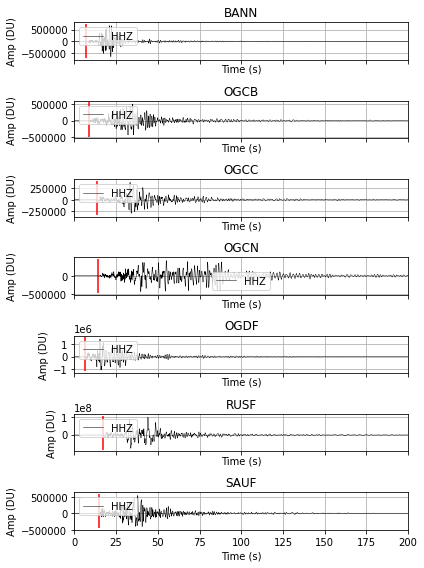

In [22]:
plot_trace(problem_corr)

Let's play with some parameter of the model, for example, let's try v = 5041;

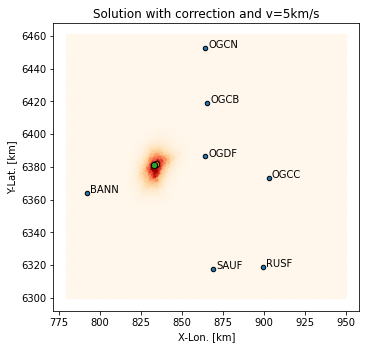

In [23]:
param_space = {}

param_space["Xmin"] = 7.8e5 
param_space["Xmax"] = 9.5e5;
param_space["Ymin"] = 6.3e6; 
param_space["Ymax"] = 6.46e6;
param_space["n_run"]= 5e5;  
param_space["v"]    = 5041; 

sol_corr = MC_Laplace(problem_corr, param_space)

ind = np.where(sol_corr[:,2]==np.max(sol_corr[:,2]))
Xprob = sol_corr[ind,0] ; Yprob = sol_corr[ind,1]


title='Solution with correction and v=5km/s'
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(sol_corr[:,0]/1000., sol_corr[:,1]/1000., edgecolors='none', 
               s=10, c=sol_corr[:,2], cmap=plt.cm.OrRd)          
ax.scatter(problem_corr["longitude"]/1000., problem_corr["latitude"]/1000.,
               edgecolors='k',s=20)
ax.scatter(Xprob/1000,Yprob/1000,edgecolors='k',s=40)

# Actual location from references:
XEQ=832796
YEQ=6381286
ax.scatter(XEQ/1000,YEQ/1000, edgecolors='k',s=40)

ax.set(xlabel='X-Lon. [km]', ylabel='Y-Lat. [km]', 
           title=title)
ax.set_aspect('equal', 'box')
for i, point in problem_corr.iterrows():
        ax.text(point['longitude']/1000.+2, point['latitude']/1000., str(point['station']))
         
plt.show()

Our solution becomes really close the real one.

## Some references

CNRS report (in French):
https://www.cnrs.fr/fr/seisme-du-teil-vers-une-reevaluation-du-risque-sismique-en-france-et-en-europe-de-louest

Journal article (in English): https://doi.org/10.1038/s43247-020-0012-z